In [1]:
import datetime
import cudf
import pandas as pd
import numpy as np
from cuml.ensemble import RandomForestClassifier
from cuml.metrics import accuracy_score

import whylogs
from whylogs.viz import ProfileVisualizer

import warnings
warnings.simplefilter('ignore')

In [2]:
heart_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data")

This dataset encodes missing values as `?`, so we will replace them with `np.nan` temporarily and then fill them with the median value for the column.

In [3]:
heart_data.replace("?", np.nan, inplace=True)
heart_data.fillna(heart_data.median(), inplace=True)
heart_data = heart_data.astype('float32')

The dataset does not come packaged with a header, so we will add that next.

More information about the data (including the header labels we'll add) can be found in `heart-disease.names`:  
https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/heart-disease.names

In [4]:
heart_data.columns = ['age', 'sex', 'cp', 'trestbps', 'chol',
                      'fbs', 'restecg', 'thalach', 'exang', 
                      'oldpeak', 'slope', 'ca', 'thal', 'target']

Finally, we will convert this object to an NVIDIA CuDF that works in the GPU.

In [5]:
cu_heart_data = cudf.from_pandas(heart_data)
cu_heart_data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,29.0,1.0,2.0,120.0,243.0,0.0,0.0,160.0,0.0,0.0,2.0,0.0,6.0,0.0
1,29.0,1.0,2.0,140.0,244.0,0.0,0.0,170.0,0.0,0.0,2.0,0.0,6.0,0.0
2,30.0,0.0,1.0,170.0,237.0,0.0,1.0,170.0,0.0,0.0,2.0,0.0,6.0,0.0
3,31.0,0.0,2.0,100.0,219.0,0.0,1.0,150.0,0.0,0.0,2.0,0.0,6.0,0.0
4,32.0,0.0,2.0,105.0,198.0,0.0,0.0,165.0,0.0,0.0,2.0,0.0,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,52.0,1.0,4.0,160.0,331.0,0.0,0.0,94.0,1.0,2.5,2.0,0.0,6.0,1.0
289,54.0,0.0,3.0,130.0,294.0,0.0,1.0,100.0,1.0,0.0,2.0,0.0,6.0,1.0
290,56.0,1.0,4.0,155.0,342.0,1.0,0.0,150.0,1.0,3.0,2.0,0.0,6.0,1.0
291,58.0,0.0,2.0,180.0,393.0,0.0,0.0,110.0,1.0,1.0,2.0,0.0,7.0,1.0


The above is our first view of the data as a CuDF on the GPU using NVIDIA's RAPIDS toolkit. 

For simplicity, we'll choose the first 200 rows as training data and the remainder as batches of testing data.

In [7]:
X_train = cu_heart_data.drop("target", axis=1)[:200]
y_train = cu_heart_data["target"][:200]

X_test1 = cu_heart_data.drop("target", axis=1)[200:231]
y_test1 = cu_heart_data["target"][200:231]
X_test2 = cu_heart_data.drop("target", axis=1)[231:262]
y_test2 = cu_heart_data["target"][231:262]
X_test3 = cu_heart_data.drop("target", axis=1)[262:]
y_test3 = cu_heart_data["target"][262:]

In addition to CuDF, we will use CuML to train a random forest classifier on the `target` variable.

In [8]:
cuml_model = RandomForestClassifier(n_estimators=40,
                   max_depth=16,
                   max_features=1.0,
                   random_state=1095)

cuml_model.fit(X_train, y_train)

RandomForestClassifier(split_criterion=0, handle=<cuml.raft.common.handle.Handle object at 0x7f5fc4a229b0>, verbose=4, output_type='cudf')

At this point, we want to log the data that we've used for training and testing with WhyLogs.

To do so, we first create a WhyLogs logging session using `get_or_create_session()`. For logging, we can create a new empty profile and track our CuDF directly from the GPU data structure.

In this example, we will do this all from memory instead of writing to a file.

In [9]:
session = whylogs.get_or_create_session()
profile = session.new_profile(dataset_name="cudf-example")
profile.track_dataframe(cu_heart_data)

WARN: Missing config


One output from WhyLogs is a summary object that can be exported as a Pandas dataframe.

In [10]:
summary = profile.flat_summary()["summary"]
summary

,column,count,null_count,bool_count,numeric_count,max,mean,min,stddev,nunique_numbers,...,ununique_str_upper,quantile_0.0000,quantile_0.0100,quantile_0.0500,quantile_0.2500,quantile_0.5000,quantile_0.7500,quantile_0.9500,quantile_0.9900,quantile_1.0000
0,age,293.0,0.0,0.0,293.0,66.0,47.894198,29.0,7.738385,37.0,...,0.0,29.0,31.0,35.0,42.0,49.0,54.0,59.0,65.0,66.0
1,restecg,293.0,0.0,0.0,293.0,2.0,0.211604,0.0,0.449050,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0
2,slope,293.0,0.0,0.0,293.0,3.0,1.962457,1.0,0.207620,3.0,...,0.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0
3,ca,293.0,0.0,0.0,293.0,0.0,0.000000,0.0,0.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,exang,293.0,0.0,0.0,293.0,1.0,0.303754,0.0,0.460665,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
5,sex,293.0,0.0,0.0,293.0,1.0,0.723549,0.0,0.448007,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
6,thalach,293.0,0.0,0.0,293.0,190.0,138.976109,82.0,23.436071,71.0,...,0.0,82.0,87.0,98.0,122.0,140.0,155.0,175.0,185.0,190.0
7,target,293.0,0.0,0.0,293.0,1.0,0.361775,0.0,0.481336,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
8,trestbps,293.0,0.0,0.0,293.0,200.0,132.583618,92.0,17.626568,31.0,...,0.0,92.0,100.0,110.0,120.0,130.0,140.0,160.0,180.0,200.0
9,chol,293.0,0.0,0.0,293.0,603.0,250.716724,85.0,64.714639,153.0,...,0.0,85.0,129.0,167.0,212.0,244.0,277.0,358.0,518.0,603.0


On each batch of inference for our model, we should also log the data.

In [11]:
profiles = []

# Model inference
output1 = X_test1.reset_index(drop=True)
output1["pred"] = cuml_model.predict(X_test1)

# Log using WhyLogs
profiles.append(session.profile_dataframe(output1, 
        dataset_timestamp=datetime.datetime.now()-datetime.timedelta(days=2)))

Let's repeat this process for our remaining batches.

In [12]:
# Inference and logging on second batch
output2 = X_test2.reset_index(drop=True)
output2["pred"] = cuml_model.predict(X_test2)
#output2 = output2.to_pandas()
profiles.append(session.profile_dataframe(output2,
        dataset_timestamp=datetime.datetime.now()-datetime.timedelta(days=1)))

# Inference and logging on third batch
output3 = X_test3.reset_index(drop=True)
output3["pred"] = cuml_model.predict(X_test3)
#output3 = output3.to_pandas()
profiles.append(session.profile_dataframe(output3, dataset_timestamp=datetime.datetime.now()))

In addition to profiling and logging the data, WhyLogs also provides a convenient visualization module that works best on multiple dataframes.

In [13]:
profiles

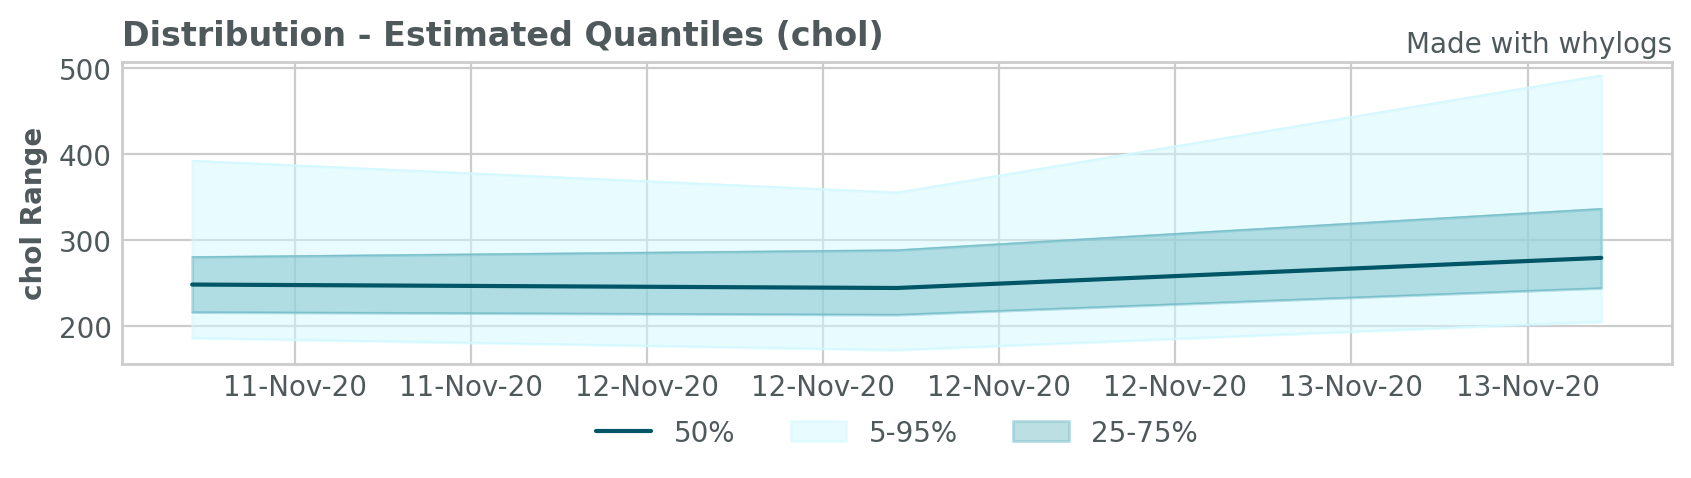

In [16]:
viz = ProfileVisualizer()
viz.set_profiles(profiles)
viz.plot_distribution("chol")

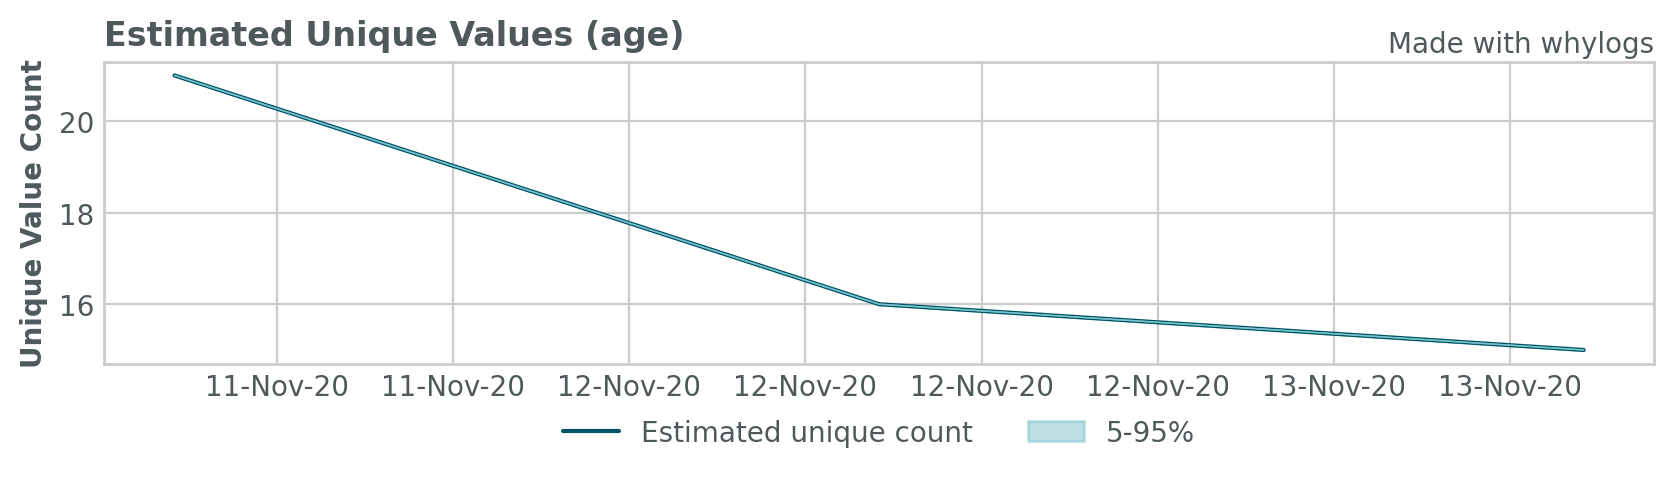

In [17]:
viz.plot_uniqueness("age")